# ITR Tool - Template Temperature Score Calculation

This notebook provides a simple example of the ITR Toolkit as a means to evaluate Portfolio Alignment.  Text boxes (called Markdown cells) like this provide some explanation, and then code cells either do the work just explained or will do work that will be explained.

All data needed to run this demonstration should be local and no acccess to the internet should be required.  However, if you want to delete a file and re-download it (to restore to its pristine state), of course you need access to the internet, and you will need a github token to access the OS-Climate hithub.

The **Sample Data template** provides both a *Read me* sheet and sheet of data dictionary *Definitions*, as well as three input data sheets:
* ITR input data: The fundamental financial, emissions, and production data of companies, listed by security instrument as company id
* ITR target input data: Short-term Emissions or Intensity reduction targets and Net-Zero attainment target dates, listed by company id
* Portfolio: A list of positions and investment value amounts

The user may choose **Benchmark Data** that forecasts intensity reductions expected from 2020-2050 by region and sector.  By default we use the OECM benchmark, but two TPI benchmarks are also available.  In all three cases we use the same projections for production grwoth forecasts.  We also use the same global carbon budget and TCRE multipliers for all benchmarks.

After scoring the portfolio, the portfolio is copied to the local file *data_dump.xlsx* which can be downloaded for further analysis.

This notebook also outputs an **enhanced portfolio** (with temperature scores), can be aggregated using various weighting methods to gain additional portfolio alignment insights.

Please enjoy learning how the ITR tool works by following the computations performed by this Jupyter Notebook!

## Getting started
Make sure you are running the notebook with the requirements installed available in the example folder.

If you see errors when attempting to load the ITR modules, go to the top-level ITR directory, activate the `itr_env` conda environment (using `conda activate itr_env` and execute the command `pip install -e .`.  Then try again, or hit the <i class="fas fa-forward"></i> button above.

In [1]:
import os
import sys
import warnings

If all is well, the list of paths below will prioritize loading from the environment established for the ITR tool.  Please contact us if not.

In [2]:
display(sys.path)

['/Users/michael/Documents/GitHub/ITR-MichaelTiemannOSC/examples',
 '/Users/michael/Documents/GitHub/ITR-MichaelTiemannOSC/examples',
 '/Library/Application Support/Blackmagic Design/DaVinci Resolve/Developer/Scripting/Modules',
 '/Users/michael/opt/miniconda3/envs/itr_env/lib/python39.zip',
 '/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9',
 '/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/lib-dynload',
 '',
 '/Users/michael/.local/lib/python3.9/site-packages',
 '/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/site-packages',
 '/Users/michael/Documents/GitHub/ITR']

In [3]:
# Load the ITR library files

import ITR
from ITR.data.excel import ExcelProviderProductionBenchmark, ExcelProviderIntensityBenchmark
from ITR.data.template import TemplateProviderCompany
from ITR.data.base_providers import BaseProviderProductionBenchmark, BaseProviderIntensityBenchmark
from ITR.data.data_warehouse import DataWarehouse
from ITR.portfolio_aggregation import PortfolioAggregationMethod
from ITR.temperature_score import TemperatureScore
from ITR.interfaces import ETimeFrames, EScope, IProductionBenchmarkScopes, IEIBenchmarkScopes
import pandas as pd

from ITR.data.osc_units import ureg, Q_, PA_

In [4]:
print("Testing unit registry\n=====================")
one_co2 = ureg("CO2e")
print(f"The gas species CO2e, which was a gwp of 1: {one_co2}")

one_Gt_co2 = ureg("Gt CO2e")
print(f"A gigaton of CO2e: {one_Gt_co2}")

Testing unit registry
The gas species CO2e, which was a gwp of 1: 1 CO2e
A gigaton of CO2e: 1 CO2e * gigametric_ton


## Load the production and intensity benchmarks

Prepare the various benchmark files; the OECM benchmark is the default after the next cell finishes.

In [5]:
import json

self_root = os.path.abspath('')
benchmark_prod_json = os.path.join(self_root, "data", "json-units", "benchmark_production_OECM.json")
benchmark_EI_OECM = os.path.join(self_root, "data", "json-units", "benchmark_EI_OECM_PC.json")
benchmark_EI_TPI = os.path.join(self_root, "data", "json-units", "benchmark_EI_TPI_2_degrees.json")
benchmark_EI_TPI_below_2 = os.path.join(self_root, "data", "json-units", "benchmark_EI_TPI_below_2_degrees.json")

# load production benchmarks
with open(benchmark_prod_json) as json_file:
    parsed_json = json.load(json_file)
prod_bms = IProductionBenchmarkScopes.parse_obj(parsed_json)
base_production_bm = BaseProviderProductionBenchmark(production_benchmarks=prod_bms)

# load intensity benchmarks

# OECM
with open(benchmark_EI_OECM) as json_file:
    parsed_json = json.load(json_file)
ei_bms = IEIBenchmarkScopes.parse_obj(parsed_json)
OECM_EI_bm = BaseProviderIntensityBenchmark(EI_benchmarks=ei_bms)

# TPI
with open(benchmark_EI_TPI) as json_file:
    parsed_json = json.load(json_file)
ei_bms = IEIBenchmarkScopes.parse_obj(parsed_json)
TPI_EI_bm = BaseProviderIntensityBenchmark(EI_benchmarks=ei_bms)

# TPI below 2
with open(benchmark_EI_TPI_below_2) as json_file:
    parsed_json = json.load(json_file)
ei_bms = IEIBenchmarkScopes.parse_obj(parsed_json)
TPI_below_2_EI_bm = BaseProviderIntensityBenchmark(EI_benchmarks=ei_bms)

base_intensity_bm = OECM_EI_bm

## Download/load the sample template data

We have prepared sample data from public sources for you to be able to run the tool as it is to familiarise yourself with how it works. To use your own data; please check out to the [Data Template Requirements](https://github.com/os-c/ITR/blob/main/docs/DataTemplateRequirements.rst) section of the technical documentation for more details on data requirements and formatting. 

*The sample data may contain estimates, simplifications, and recategorizations.  It is intended to be generally representative, but not authoritative, and should not be relied upon to make investment decisions.*

In [6]:
import urllib.request
from github import Github

# Create a Github instance with an access token.
# Use your shell's `export` command to inject your token into the GITHUB_TOKEN environment variable before starting this jupyter-lab instance.
gh = Github(os.environ['GITHUB_TOKEN'])

# Get repository by name and select the proper branch
repo = gh.get_repo("os-climate/ITR").get_branch(branch="develop")

if not os.path.isdir("data"):
    os.mkdir("data")

for filename in ['data/20220927 ITR Tool Sample Data.xlsx',
                 'data/OECM_EI_and_production_benchmarks.xlsx',
                 'utils.py']:
    if not os.path.isfile(filename):
        # Get a specific content file:
        contents = repo.get_contents(f"examples/{filename}")

        # Donwnload file form ContenFile object info:
        urllib.urlretrieve(contents.download_url, filename)

try:  # Import statement when run in remote Jupyter servers from AWS Google etc..
    from utils import collect_company_contributions, plot_grouped_statistics, anonymize, \
        plot_grouped_heatmap, print_grouped_scores, get_contributions_per_group
except:  # Import statement when run locally
    from utils import collect_company_contributions, plot_grouped_statistics, anonymize, \
        plot_grouped_heatmap, print_grouped_scores, get_contributions_per_group

template_data_path = "data/20220927 ITR Tool Sample Data.xlsx"

### Logging
The ITR module uses the Python standard library logging utilities to send log messages. The log level can be changed according to the user's needs.

In [7]:
import logging
root_logger = logging.getLogger()
root_logger.setLevel("INFO")

## Create a data provider
Data providers let you connect to the data source of your choice. In this case we are connecting to Excel as a data provider for benchmark information and we are using the ITR Data Template for company and portfolio information, using *template_data_path* as the pathname to the data.  If you want to supply your own data file, you can set the pathname in the first line of the next cell.

In [8]:
# Remove the # and space on the next line to point the template_data_path variable at your own data
# template_data_path = "data/your_template_here.xlsx"

template_company_data = TemplateProviderCompany(excel_path=template_data_path)

2022-09-27 08:39:24,284 - ITR.data.template - WARNING - Missing target start year set to 2021 for companies with ID: ['US0185223007', 'US0188021085', 'US0236081024', 'US0236081024', 'US0255371017', 'US05351W1036-E', 'US05351W1036-U', 'US0921131092', 'US0921131092', 'US1442851036', 'US18551QAA58', 'US25746U1097', 'US26441C2044', 'US30034W1062', 'US5526901096', 'JP3633400001']


## Create the Data Warehouse

In [9]:
template_company_data._companies[0].production_metric

ProductionMetric(units='GWh')

In [10]:
template_provider = DataWarehouse(template_company_data, base_production_bm, base_intensity_bm)

# Fills in template_company_data._companies[0].projected_targets.S1S2

print(f"Benchmark Temperature = {base_intensity_bm.benchmark_temperature}\n\
Benchmark Global Budget = {base_intensity_bm.benchmark_global_budget}\n\
AFOLU included = {base_intensity_bm.is_AFOLU_included}")

Benchmark Temperature = 1.5 delta_degree_Celsius
Benchmark Global Budget = 521.0526315789474 CO2 * gigametric_ton
AFOLU included = False


In [11]:
ureg("kg CO2/(passenger km)")

1.0 <Unit('CO2 * kilogram / pkm')>

## Load your portfolio

The portfolio data is a sheet in the Data Template named "Portfolio".

Please see the technical documentation in the [Data Template Requirements](https://github.com/os-c/ITR/blob/main/docs/DataTemplateRequirements.rst) section for details on data requirements.

In [12]:
df_portfolio = pd.read_excel(template_data_path, sheet_name="Portfolio")
display(df_portfolio.tail())

,company_name,company_lei,company_id,company_isin,investment_value
69,Versant Power,NQZVQT2P5IUF2PGA1Q48,CA2908761018,CA2908761018,93382240
70,Vistra Corp.,549300KP43CPCUJOOG15,US92840M1027,US92840M1027,145262507
71,WEC Energy Group,549300IGLYTZUK3PVP70,US92939U1060,US92939U1060,211716750
72,WORTHINGTON INDUSTRIES INC,1WRCIANKYOIK6KYE5E82,US9818111026,US9818111026,226939344
73,"Xcel Energy, Inc.",LGJNMI9GH8XIDG5RCM61,US98389B1008,US98389B1008,80944002


To load the data from the data provider, we have to pass a list of IPortfolioCompany instances. The module has a strict [data model](https://ofbdabv.github.io/ITR/autoapi/ITR/interfaces/index.html) to convert Pandas Dataframe to the right object types we supplied a utility function.


In [13]:
companies = ITR.utils.dataframe_to_portfolio(df_portfolio)

## Calculate the temperature scores
In the enhanced portfolio you'll find your original portfolio, with calculated temperature scores, trajectory and target scores and overshoot/undershoot ration, and a temperature_result which is current set to zero for all valid calculations.

In [14]:
temperature_score = TemperatureScore(
    time_frames = [ETimeFrames.LONG],
    scopes=[EScope.S1S2],
    aggregation_method=PortfolioAggregationMethod.WATS # Options for the aggregation method are WATS, TETS, AOTS, MOTS, EOTS, ECOTS, and ROTS.
)
enhanced_portfolio = temperature_score.calculate(data_warehouse=template_provider, portfolio=companies)

For every company the tool assigns a score for all the requested timeframe and scope combinations. For now the ITR methodolgy only supportt a long timeframe in combination with a S1S2 scope

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    display(enhanced_portfolio[['company_name', 'time_frame', 'scope', 'temperature_score']])

,company_name,time_frame,scope,temperature_score
0,AES Corp.,LONG,S1S2,2.79
1,"ALLETE, Inc.",LONG,S1S2,2.51
2,Alliant Energy,LONG,S1S2,2.12
3,Ameren Corp.,LONG,S1S2,3.53
4,"American Electric Power Co., Inc.",LONG,S1S2,2.97
...,...,...,...,...
69,Versant Power,LONG,S1S2,1.92
70,Vistra Corp.,LONG,S1S2,3.0
71,WEC Energy Group,LONG,S1S2,2.73
72,WORTHINGTON INDUSTRIES INC,LONG,S1S2,1.21


In [16]:
data = enhanced_portfolio[(enhanced_portfolio.scope==EScope.S1S2)&(enhanced_portfolio.temperature_score>Q_(3, 'delta_degC'))]
data

/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)
/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)


,company_name,company_id,region,sector,target_probability,target_data,historic_data,country,emissions_metric,production_metric,...,company_isin,investment_value,scope,time_frame,temperature_score,trajectory_score,trajectory_overshoot_ratio,target_score,target_overshoot_ratio,score_result_type
3,Ameren Corp.,US0236081024,North America,Electricity Utilities,0.5,"[{'netzero_year': 2050, 'target_type': 'absolu...","{'productions': [{'year': 2016, 'value': 38.50...",US,{'units': 'Mt CO2'},{'units': 'TWh'},...,US0236081024,224938701.0,S1S2,LONG,3.53,4.980644132775656,12.125276489775484 dimensionless,2.076778100723289,2.843571361797634 dimensionless,EScoreResultType.COMPLETE
13,CMS Energy Corp.,US1258961002,North America,Electricity Utilities,0.5,"[{'netzero_year': 2050, 'target_type': 'absolu...","{'productions': [{'year': 2016, 'value': 16.69...",US,{'units': 'Mt CO2'},{'units': 'TWh'},...,US1258961002,80836672.0,S1S2,LONG,3.17,4.948700352277477,12.023173724708393 dimensionless,1.383190991577245,0.6266402235831715 dimensionless,EScoreResultType.COMPLETE
15,Cleco Partners LP,US18551QAA58,North America,Electricity Utilities,0.5,"[{'netzero_year': 2050, 'target_type': 'absolu...","{'productions': [{'year': 2016, 'value': 13.52...",US,{'units': 'Mt CO2'},{'units': 'TWh'},...,US18551QAA58,131743976.0,S1S2,LONG,3.37,4.745932694577137,11.375062004852246 dimensionless,2.0030324738595287,2.6078562304960946 dimensionless,EScoreResultType.COMPLETE
17,DTE Energy,US2333311072,North America,Electricity Utilities,0.5,"[{'netzero_year': 2050, 'target_type': 'absolu...","{'productions': [{'year': 2016, 'value': 38.33...",US,{'units': 'Mt CO2'},{'units': 'TWh'},...,US2333311072,211258140.0,S1S2,LONG,4.62,7.2916056579060395,19.511864989935116 dimensionless,1.9548867542267212,2.4539667714530498 dimensionless,EScoreResultType.COMPLETE
20,Electricité de France,FR0010242511,Europe,Electricity Utilities,0.5,"[{'netzero_year': 2050, 'target_type': 'absolu...","{'productions': [{'year': 2016, 'value': nan g...",FR,{'units': 'Mt CO2'},{'units': 'GWh'},...,FR0010242511,121931257.0,S1S2,LONG,4.06,4.952722181446704,12.036028805490991 dimensionless,3.1655306261299394,6.323580352096504 dimensionless,EScoreResultType.COMPLETE
33,"Hawaiian Electric Industries, Inc.",US4198701009,North America,Electricity Utilities,0.5,"[{'netzero_year': 2050, 'target_type': 'intens...","{'productions': [{'year': 2016, 'value': 4.942...",US,{'units': 'Mt CO2'},{'units': 'TWh'},...,US4198701009,143002854.0,S1S2,LONG,4.08,5.675990353819276,14.347830324677808 dimensionless,2.4748692850361182,4.1160009250263725 dimensionless,EScoreResultType.COMPLETE
36,MDU Resources Group,US5526901096,North America,Electricity Utilities,0.5,"[{'netzero_year': 2050, 'target_type': 'intens...","{'productions': [{'year': 2016, 'value': 2.187...",US,{'units': 'Mt CO2'},{'units': 'TWh'},...,US5526901096,208984600.0,S1S2,LONG,3.9,5.367754118686206,13.362606553097287 dimensionless,2.439572044121261,4.0031794042032 dimensionless,EScoreResultType.COMPLETE
37,National Grid PLC,US6362744095,Europe,Electricity Utilities,0.5,"[{'netzero_year': 2050, 'target_type': 'absolu...","{'productions': [{'year': 2016, 'value': 9.668...",GB,{'units': 'Mt CO2'},{'units': 'TWh'},...,US6362744095,165156417.0,S1S2,LONG,3.11,3.983923262728285,8.939430755651617 dimensionless,2.2454712047191796,3.382769668858145 dimensionless,EScoreResultType.COMPLETE
40,Nisource Inc.,US65473P1057,North America,Electricity Utilities,0.5,"[{'netzero_year': 2050, 'target_type': 'absolu...","{'productions': [{'year': 2016, 'value': 11.78...",US,{'units': 'Mt CO2'},{'units': 'TWh'},...,US65473P1057,99393511.0,S1S2,LONG,3.43,5.320902857833406,13.212854607480732 dimensionless,1.5396373623610988,1.1266939677745758 dimensionless,EScoreResultType.COMPLETE
43,OG&E Energy Corp.,US6708371033,North America,Electricity Utilities,0.5,"[{'netzero_year': 2050, 'target_type': 'absolu...","{'productions': [{'year': 2016, 'value': 50505...",US,{'units': 't CO2'},{'unit

## Calculate the aggregated temperature score
Calculate an aggregated temperature score. This can be done using different aggregation methods. Here we'll use the "Weighted Average Temperature Score" (WATS) by initializing the TemperatureScore Object with PortfolioAggregationMethod.WATS. The temperature scores are calculated per time-frame/scope combination.


In [17]:
aggregated_scores = temperature_score.aggregate_scores(enhanced_portfolio)
print(f"Temperature Score aggregation method = {temperature_score.aggregation_method}")

Temperature Score aggregation method = PortfolioAggregationMethod.WATS


/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)
/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1983: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


In [18]:
aggregated_scores.long.S1S2.all.score

2.206514037265527 <Unit('delta_degree_Celsius')>

## Display aggregation data in various ways


The first analysis of your portfolio could be to understand if you have any particular hotspots in your portfolio. We can do that by analysing different groupings of companies.

The tool allows you to calculate temperature scores for _groups_ of companies. In this example we group the scores by sector and region, and leave the timeframe and scope unchanged. Any categorical variable in the data provided by you or your data provider (in the `test_company_data.xlsx` imported above) can be used as grouping variable, e.g. sectors, industries, regions, countries, market cap buckets, as well as the additional fields you imported via the portfolio data.

You can change the variable by which the data is grouped by replacing the fourth line in the following cell. For example, replacing "grouping=['sector', 'region']" by "grouping=['sector', 'country']" would result in temperature scores per sector per country. 
If you want to change the time frame as well, please refer to the section 'Calculate the company temperature scores' above.



In [19]:
grouping = ['sector', 'region']
temperature_score.grouping = grouping
grouped_portfolio = temperature_score.calculate(data_warehouse=template_provider, portfolio=companies)
grouped_aggregations = temperature_score.aggregate_scores(grouped_portfolio)

/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)
/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1983: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values



The aggregated scores can then be used, for example, to show the relation between sectors and regions with respect to temperature score.
A visualization of this relation is shown in the heatmap below. The grey fields indicate that the portfolio contains no assest for those combinations.

#### Quick analysis: Heat Map

We can see here that our North American Steel is in reasonable shape. While Asian Steel can be improved as shown in the drill down below the graph



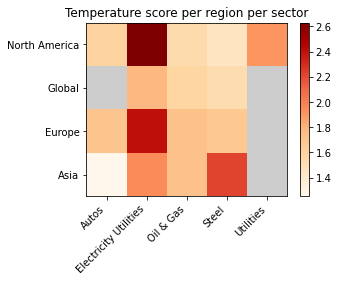

In [20]:
analysis_parameters = ([ETimeFrames.LONG], [EScope.S1S2], grouping)
plot_grouped_heatmap(grouped_aggregations, analysis_parameters)

In [21]:
region = 'Asia'
sector = 'Steel'
group = sector + '-' + region
analysis_parameters = ([ETimeFrames.LONG], [EScope.S1S2], grouping)
group_contributions = get_contributions_per_group(grouped_aggregations, analysis_parameters, group)
group_contributions.round(2)

,group,company_name,company_id,temperature_score,contribution_relative
0,Steel-Asia,POSCO,KR7005490008,2.21 delta_degree_Celsius,81.52710143203362 percent
1,Steel-Asia,NIPPON STEEL CORP,JP3381000003,2.26 delta_degree_Celsius,18.472898567966386 percent


#### Sector analysis

Sector analysis may help us with bringing some clarity into our analysis from the heatmap above. In order to identify the companies that your portfolio would most benefit from engaging with, we can start with identifying the biggest contributing sectors to the portfolio's temperature score, as in our example below.

Contributions can be identified on an individual company level, as well as contributions from companies grouped by one of their characteristics, e.g. sector or region. The exact definitions of companies' contributions to the portfolio temperature scores depend on the selected aggregation method.

You can group companies on any categorical variable (e.g. sectors, countries, market cap buckets, investment strategies, etc)  you provide through your dataprovider, in this example in the test_company_data.xlsx imported above.

For our analysis we select one time-frame (LONG) and one scope (S1+S2) and group the outcomes on sector and compare AUM to temperature score contribution. We also then display the sector temperature scores.

#### Quick analysis

In this example we can see that both sectors Steel and Electricity are scoring above 2.0C. 


In [22]:
time_frames = [ETimeFrames.LONG]
scopes = [EScope.S1S2, EScope.S3]
grouping = ['sector']
analysis_parameters = (time_frames, scopes, grouping)

temperature_score = TemperatureScore(time_frames=time_frames,
                                     scopes=scopes,
                                     grouping=grouping, aggregation_method=PortfolioAggregationMethod.WATS)
enhanced_portfolio = temperature_score.calculate(data_warehouse=template_provider, portfolio=companies)
aggregated_portfolio = temperature_score.aggregate_scores(enhanced_portfolio)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    company_contributions = collect_company_contributions(aggregated_portfolio, enhanced_portfolio, analysis_parameters)

/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)
/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1983: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)
/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1983: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


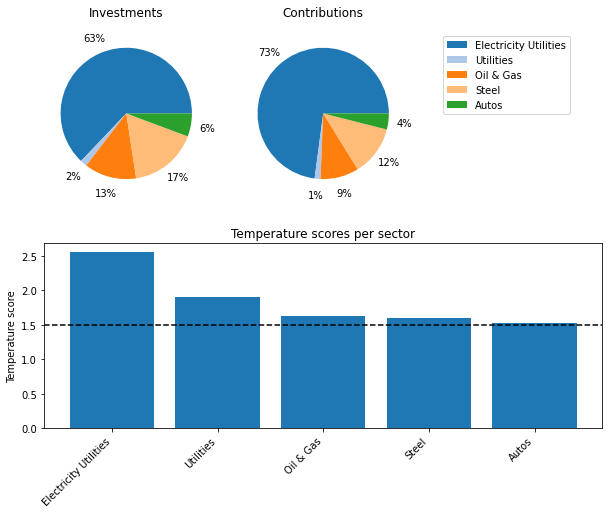

In [23]:
plot_grouped_statistics(aggregated_portfolio, company_contributions, analysis_parameters)

We can use what we learned from this analysis to drill into a few of the highest contributing scoring sectors to see which
companies are the biggest contributors on the sector level. Considering the Steel sector, for instance, in the
table below.


In [24]:
sector_contributions = company_contributions[['company_name', 'company_id', 'sector', 'contribution', 'temperature_score', 'ownership_percentage', 'portfolio_percentage']]
sector_contributions.loc[sector_contributions['sector'] == 'Steel'][:10].round(2)

,company_name,company_id,sector,contribution,temperature_score,ownership_percentage,portfolio_percentage
172,POSCO,KR7005490008,Steel,1.9977053617247646 percent,2.21 delta_degree_Celsius,0.93,0.50
25,POSCO,KR7005490008,Steel,1.9977053617247646 percent,2.21 delta_degree_Celsius,0.93,0.50
173,POSCO,KR7005490008,Steel,1.9977053617247646 percent,2.21 delta_degree_Celsius,0.93,0.50
24,POSCO,KR7005490008,Steel,1.9977053617247646 percent,2.21 delta_degree_Celsius,0.93,0.50
178,GERDAU S.A.,US3737371050,Steel,1.8640674818926724 percent,1.52 delta_degree_Celsius,13.39,0.68
31,GERDAU S.A.,US3737371050,Steel,1.8640674818926724 percent,1.52 delta_degree_Celsius,13.39,0.68
30,GERDAU S.A.,US3737371050,Steel,1.8640674818926724 percent,1.52 delta_degree_Celsius,13.39,0.68
179,GERDAU S.A.,US3737371050,Steel,1.8640674818926724 percent,1.52 delta_degree_Celsius,13.39,0.68
47,STEEL DYNAMICS INC,US8581191009,Steel,1.387395966117666 percent,1.4 delta_degree_Celsius,4.14,0.55
46,STEEL DYNAMICS INC,US8581191009,Steel,1.387395966117666 percent,1.4 delta_degree_Celsius,4.14,0.55


### Save portfolio data for further analysis
To take your analysis outside of this notebook and for example for internal and client reporting, you can export all data to Excel and the clipboard for pasting into and analysing in other applications.

If you run the ITR tool locally or from Google Colab, you:
- Specify the filenames of the output files in the cell below, e.g. change 'data_dump.xlsx' in the first line to 'TS_output.xlsx'
- Run the cell below

In [25]:
data_dump_filename = 'data_dump.xlsx'
enhanced_portfolio.set_index(['company_name', 'company_id']).to_excel(data_dump_filename)

### Compare OECD and non-OECD results

There are currently 37 members of the OECD (text list maintained on the OECD website).  We use a simple CSV file containing data correct as of June 6th, 2022.

In [26]:
from ITR.utils import get_project_root
pkg_root = get_project_root()

# When connected to the Data Commons, this would be the kind of data we could simply load from a table.
# As this is a stand-alone program, we must load the data from a file.

oecd_df = pd.read_csv(f"{pkg_root}/data/input/oecd_iso.csv")

We reuse the calculated `grouped_portfolio` from above, and then add the additional OECD discriminator to it.  We can add arbitrary columns and group on them in this way.  (And of course we can recompute a fresh `grouped_portfolio` if we wish.)

Because of the way we generate grouped and aggregated data (which uses dash (-) as a separator), we spell Non-OECD with an underscore  (non_oecd) instead of a dash.

/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/site-packages/pint_pandas/pint_array.py:648: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.array(qtys, dtype="object", copy=copy)
/Users/michael/opt/miniconda3/envs/itr_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1983: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


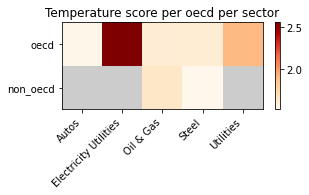

In [27]:
grouping = ['sector', 'oecd']
grouped_portfolio.loc[:, 'oecd'] = grouped_portfolio.country.map(lambda x: 'oecd' if x in oecd_df.alpha_2.values else 'non_oecd')
temperature_score.grouping = grouping
grouped_aggregations = temperature_score.aggregate_scores(grouped_portfolio)
analysis_parameters = ([ETimeFrames.LONG], [EScope.S1S2], grouping)
plot_grouped_heatmap(grouped_aggregations, analysis_parameters)